# train / test 나누기
- 한 번만 실행

In [1]:
import random
import os
import shutil

In [2]:
train_path = './data/train'
test_path = './data/test'

train_set_len = int(len(os.listdir(train_path)) * 0.8) 
test_set_len = len(os.listdir(train_path)) - train_set_len

file_list = []
for file in os.listdir(train_path):
    file_path = f'{train_path}/{file}'
    file_list.append(file_path)
    
for file in random.sample(file_list, test_set_len):
    move_dir = f'{test_path}{file[0][12:]}'
    shutil.move(file, move_dir)


In [3]:
len(os.listdir(test_path))

9600

# 참조 : https://github.com/qjadud1994/CRNN-Keras

In [1]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
CHAR_VECTOR = "0123456789dfghijklmno"
# one-hot으로 쓰기위한 letters 

letters = [letter for letter in CHAR_VECTOR]

num_classes = len(letters) + 1

img_w, img_h = 160, 28

# Network parameters
# batch_size = 128
# val_batch_size = 16
batch_size = 64
val_batch_size = 16

downsample_factor = 2
max_text_len = 4

In [3]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
K.set_learning_phase(0)

# # Loss and train functions, network architecture
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(training):
    input_shape = (img_w, img_h, 1)     # (160, 28, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 160, 28, 1)

    inner = Conv2D(64, (2, 2), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 48, 56, 32)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None, 80, 14, 64)
    print(inner)
    inner = Conv2D(256, (2, 2), padding='same', name='conv2')(inner)  # 
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max2')(inner)  # (None, 80, 7, 256)
    print(inner)
    inner = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal', name='conv3')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner) # (?, 80, 7, 256)
    print(inner)
    # CNN to RNN
    inner = Reshape(target_shape=((80, 7*256)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 80, 1792)

    # RNN layer
    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    
    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') # (None ,8)
    input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
    label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)
    
    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

In [4]:
model = get_Model(True)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Tensor("max1/MaxPool:0", shape=(?, 80, 14, 64), dtype=float32)
Tensor("max2/MaxPool:0", shape=(?, 80, 7, 256), dtype=float32)
Tensor("activation_3/Relu:0", shape=(?, 80, 7, 256), dtype=float32)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 160, 28, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 28, 64)  320         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 

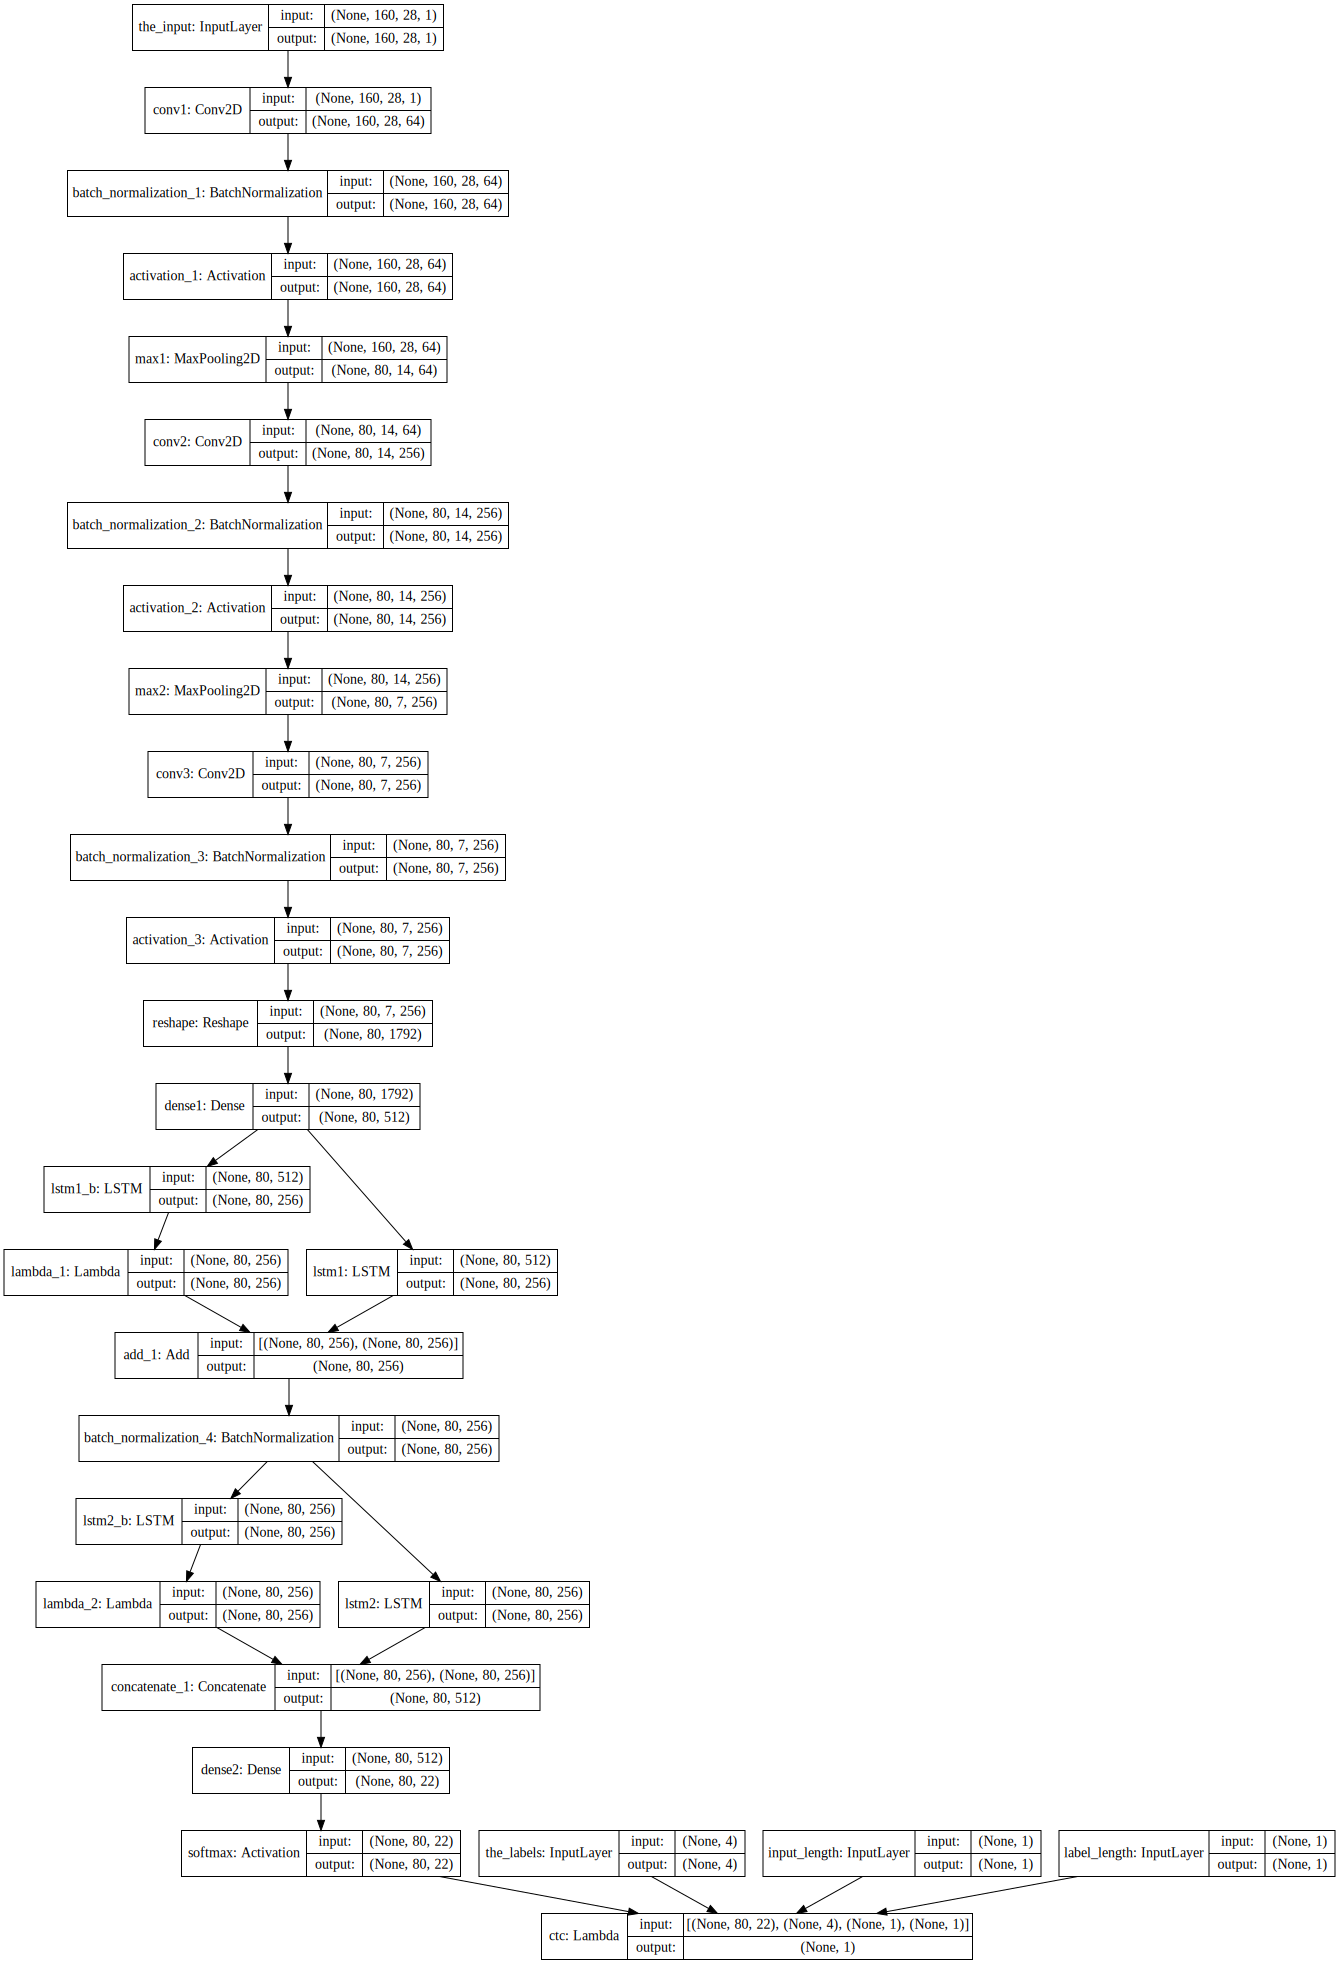

In [5]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='./CRNN.svg')

In [4]:
import cv2
import os, random
import numpy as np

# # Input data generator
def labels_to_text(labels):     # letters의 index -> text (string)
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):      # text를 letters 배열에서의 인덱스 값으로 변환
    return list(map(lambda x: letters.index(x), text))


class TextImageGenerator:
    def __init__(self, img_dirpath, img_w, img_h,
                 batch_size, downsample_factor, max_text_len=4):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        self.img_dirpath = img_dirpath                  # image dir path
        self.img_dir = os.listdir(self.img_dirpath)     # images list
        self.n = len(self.img_dir)                      # number of images
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []

    ## samples의 이미지 목록들을 opencv로 읽어 저장하기, texts에는 label 저장
    def build_data(self):
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.img_dir):
            img = cv2.imread(self.img_dirpath + img_file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            self.imgs[i, :, :] = img
            img_file = img_file.split('_')[-1]
            self.texts.append(img_file[0:-4])
        print(len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")

    def next_sample(self):      ## index max -> 0 으로 만들기
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):       ## batch size만큼 가져오기
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])     # (bs, 128, 64, 1)
            Y_data = np.ones([self.batch_size, self.max_text_len])             # (bs, 9)
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)  # (bs, 1)
            label_length = np.zeros((self.batch_size, 1))           # (bs, 1)

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                label_length[i] = len(text)
#                 print(text)
#                 print(f'Y_data[{i}] : {Y_data[i]}\ninput_length : {input_length}\n label_length[{i}]: {label_length[i]}\n')
            
            # dict 형태로 복사
            inputs = {
                'the_input': X_data,  # (bs, 128, 64, 1) --> image
                'the_labels': Y_data,  # (bs, 8) --> text를 label로 바꾼 값 (48 17 48 ...)같은
                'input_length': input_length,  # (bs, 1) -> 모든 원소 value = 30 --> 
                'label_length': label_length  # (bs, 1) -> 모든 원소 value = 8 --> label의 길이
            }
            outputs = {'ctc': np.zeros([self.batch_size])}   # (bs, 1) -> 모든 원소 0
            yield (inputs, outputs)

In [5]:
from keras import backend as K
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
K.set_learning_phase(0)


# # Model description and training

model = get_Model(training=True)

train_file_path = './data/train/'
tiger_train = TextImageGenerator(train_file_path, img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()

valid_file_path = './data/test/'
tiger_val = TextImageGenerator(valid_file_path, img_w, img_h, val_batch_size, downsample_factor)
tiger_val.build_data()

ada = Adadelta()
# loss의 변화량이 0.001보다 적으면 학습의 개선이 없다 판단하고 4 epoch만큼 지속되면 종료
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
#checkpoint = ModelCheckpoint(filepath='LSTM+BN5--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=ada)

# generator로 생성된 배치로 학습할떄 fit_generator 사용
# 
model.fit_generator(generator=tiger_train.next_batch(),
                    steps_per_epoch=int(tiger_train.n / batch_size),
                    epochs=20,
                    #callbacks=[checkpoint],
                    validation_data=tiger_val.next_batch(),
                    validation_steps=int(tiger_val.n / val_batch_size))

Tensor("max1_1/MaxPool:0", shape=(?, 80, 14, 64), dtype=float32)
Tensor("max2_1/MaxPool:0", shape=(?, 80, 7, 256), dtype=float32)
Tensor("activation_6/Relu:0", shape=(?, 80, 7, 256), dtype=float32)
38400  Image Loading start...
True
38400  Image Loading finish...
9600  Image Loading start...
True
9600  Image Loading finish...
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
600/600 [==============================] - 956s 2s/step - loss: 15.0069 - val_loss: 18.5316
Epoch 2/20
600/600 [==============================] - 911s 2s/step - loss: 13.9556 - val_loss: 9.7696
Epoch 3/20
600/600 [==============================] - 903s 2s/step - loss: 6.2440 - val_loss: 9.7113
Epoch 4/20
600/600 [==============================] - 913s 2s/step - loss: 3.8480 - val_loss: 0.0767
Epoch 5/20
600/600 [==============================] - 908s 2s/step - loss: 2.0583 - val_loss: 0.0194
Epoch 6/20
600/600 [==============================] - 898s 1s/step - loss: 0.0354 - va

KeyboardInterrupt: 

In [6]:
model.save_weights("./13_model.h5")

In [20]:
import cv2
import itertools, os, time
import numpy as np
import argparse
from keras import backend as K
K.set_learning_phase(0)

label_dict = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', '0':'0', 'd':'.',
              'f':'어', 'g':'깨', 'h':'넓', 'i':'이', 'j':'너', 'k':'비', 'l':'팔', 'm':'길', 'n':'소', 'o':'매'}

def decode_label(out):
    # out : (1, 32, 42)
#     print(f'decode_label.. out.shape : {out.shape}')
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
#     print(f'decode_label.. out_best : {out_best}')
#    print(f'decode_label.. out_best.shape : {len(out_best)}')
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
#     print(f'decode_label..groupby.. out_best : {out_best}')
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
#     print(f'decode_label..groupby.. outstr : {outstr}')
    return outstr


# A99th3954같은 형태의 label이 예측되게 되는데 각 label의 위치값으로 번호판 예측
def label_to_hangul(label):  # eng -> hangul
    lb_text = ''
    for lb in label:
#         if lb == 'd':
#             lb_text += '.'
#         else:
#             lb_text += lb
        lb_text += label_dict[lb]
    return lb_text

In [8]:
model = get_Model(training=False)

try:
    model.load_weights('13_model.h5')
    print("...Previous weight data...")
except:
    raise Exception("No weight file!")
test_dir = './data/test2/'
test_imgs = os.listdir(test_dir)
total = 0
acc = 0
letter_total = 0
letter_acc = 0
start = time.time()
for test_img in test_imgs:
    
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (160, 28))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    #print(img_pred.shape)
    img_pred = img_pred.T
    #print(img_pred.shape)
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model.predict(img_pred)
    decode_label(net_out_value)
    real_label = test_img.split('_')[-1]
    print(f'real label : {real_label}')
    print('***************')

Tensor("max1_2/MaxPool:0", shape=(?, 80, 14, 64), dtype=float32)
Tensor("max2_2/MaxPool:0", shape=(?, 80, 7, 256), dtype=float32)
Tensor("activation_9/Relu:0", shape=(?, 80, 7, 256), dtype=float32)
...Previous weight data...
decode_label..groupby.. outstr : 4
real label : 64.jpg
***************
decode_label..groupby.. outstr : 694
real label : 694.jpg
***************
decode_label..groupby.. outstr : 8d2
real label : 8d2.jpg
***************
decode_label..groupby.. outstr : 3308
real label : 3308.jpg
***************
decode_label..groupby.. outstr : 3886
real label : 3886.jpg
***************
decode_label..groupby.. outstr : 5d3
real label : 5d3.jpg
***************
decode_label..groupby.. outstr : 7414
real label : 7414.jpg
***************


In [11]:
model = get_Model(training=False)

try:
    model.load_weights('13_model.h5')
    print("...Previous weight data...")
except:
    raise Exception("No weight file!")
test_dir = './data/test/'
test_imgs = os.listdir(test_dir)
total = 0
acc = 0
letter_total = 0
letter_acc = 0
start = time.time()
for test_img in test_imgs[-12:]:
    
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (160, 28))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    #print(img_pred.shape)
    img_pred = img_pred.T
    #print(img_pred.shape)
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model.predict(img_pred)
    decode_label(net_out_value)
    real_label = test_img.split('_')[-1]
    print(f'real label : {real_label}')
    print('***************')

Tensor("max1_5/MaxPool:0", shape=(?, 80, 14, 64), dtype=float32)
Tensor("max2_5/MaxPool:0", shape=(?, 80, 7, 256), dtype=float32)
Tensor("activation_18/Relu:0", shape=(?, 80, 7, 256), dtype=float32)
...Previous weight data...
decode_label..groupby.. outstr : ommf
real label : ommf.jpg
***************
decode_label..groupby.. outstr : ommh
real label : ommh.jpg
***************
decode_label..groupby.. outstr : ommo
real label : ommo.jpg
***************
decode_label..groupby.. outstr : omoh
real label : omoh.jpg
***************
decode_label..groupby.. outstr : ongn
real label : ongn.jpg
***************
decode_label..groupby.. outstr : ongo
real label : ongo.jpg
***************
decode_label..groupby.. outstr : onkg
real label : onkg.jpg
***************
decode_label..groupby.. outstr : onmm
real label : onmm.jpg
***************
decode_label..groupby.. outstr : onmn
real label : onmn.jpg
***************
decode_label..groupby.. outstr : onok
real label : onok.jpg
***************
decode_label..

In [8]:
test_dir = './data/test/'
test_imgs = os.listdir(test_dir)
total = 0
acc = 0
letter_total = 0
letter_acc = 0
start = time.time()

In [10]:
test_imgs[0]

'font1_c1b1_0034.jpg'

In [21]:
model = get_Model(training=False)

try:
    model.load_weights('13_model.h5')
    print("...Previous weight data...")
except:
    raise Exception("No weight file!")
test_dir = './data/test/'
test_imgs = os.listdir(test_dir)
total = 0
acc = 0
letter_total = 0
letter_acc = 0
start = time.time()
for idx, test_img in enumerate(test_imgs):
    if idx % 1000 == 0:
        print(f'{idx}/{len(test_imgs)}')
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (160, 28))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    #print(img_pred.shape)
    img_pred = img_pred.T
    #print(img_pred.shape)
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model.predict(img_pred)
    pred_texts = decode_label(net_out_value)
    test_label = test_img.split('_')[-1][:-4]
    for i in range(min(len(pred_texts), len(test_label))):
        if pred_texts[i] == test_label[i]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(test_label))

    if pred_texts == test_label:
        acc += 1
    total += 1
#     print('Predicted: %s  /  True: %s' % (label_to_hangul(pred_texts), label_to_hangul(test_label)))

end = time.time()
total_time = (end - start)
print("Time : ",total_time / total)
print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

Tensor("max1_5/MaxPool:0", shape=(?, 80, 14, 64), dtype=float32)
Tensor("max2_5/MaxPool:0", shape=(?, 80, 7, 256), dtype=float32)
Tensor("activation_18/Relu:0", shape=(?, 80, 7, 256), dtype=float32)
...Previous weight data...
0/9600
1000/9600
2000/9600
3000/9600


KeyboardInterrupt: 